<a href="https://colab.research.google.com/github/Patatone/Network-failure-cause-identification/blob/main/Failure_cause_identification_with_different_failures_location_IPY.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from sklearnex import patch_sklearn
patch_sklearn()

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import hyperopt
import time
import sklearn.metrics as mt
import pickle

from xgboost import Booster
from xgboost import XGBClassifier
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier

In [2]:
#################################################################################################
###### The function load_window_dataset() that takes in input window data file, and 
###### label to be assigned and returns numpy arrays with features and labels
#################################################################################################

def load_window_dataset(X, y, filename, label):
#Inputs: - X: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only features)
#        - y: current matrix of datapoints where we want to APPEND the datapoints retrieved from filename (only labels)
#        - filename: full name (with path) of the file to be read (it must be a window dataset file created above)
#        - label: integer, label to be assigned to the datapoints retrieved from filename; it may differ from labels already included in current y
#Outputs: - X: updated X (including features for the new data points retrieved from filename)
#         - y: updated y (including labels for the new data points)
#This function to X and y in input the new datapoints retrieved from filename and return updated X and y
#The function handle the case when X and y are empty (initialized as None)

    data = pd.read_csv(filename)

    if X is None:
        X = data.to_numpy()
        # full() function puts in all X.shape[0] elements the value "label"
        y = np.full(X.shape[0], label)
    else:
        X_temp = data.to_numpy()
        y_temp = np.full(X_temp.shape[0], label)
        X = np.append(X, X_temp, axis = 0) #F: axis=0-->stack X and X_temp vertically (increase no of rows)
        y = np.append(y, y_temp)

    return X, y



In [3]:
##########################################################################################
###### Use function load_window_dataset() with datasets of for all scenarios  
###### using window length = 10 and spacing = 1. Finally, perform features scaling 
##########################################################################################

X=None 
y=None
length=10
spacing=1
folderpath='../Features'

for filename in os.listdir(folderpath):   
    if filename.endswith('_sp' + str(spacing) + '_w' + str(length) + '.dat'):
        print(filename)
        label = 0
        if int(filename[9]) > 5:
          label = 1
        fullname = folderpath + '/' + filename
#------------------------------------------------------------
        X, y = load_window_dataset(X, y, fullname, label)
#------------------------------------------------------------
        print('current shape of X: ' +str(X.shape))
        print('current shape of y: ' +str(y.shape))

#All scenario correlated ONLY TO "length" and "spacing" variables
print(X)
print(y)
print(X.shape)
print(y.shape)

# Features scaling 
scaler = StandardScaler()
X = scaler.fit_transform(X)

print(X)
print(y)
print(X.shape)
print(y.shape)



Scenario_1_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (21591, 6)
current shape of y: (21591,)
Scenario_1_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (43182, 6)
current shape of y: (43182,)
Scenario_1_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of X: (64773, 6)
current shape of y: (64773,)
Scenario_2_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (86364, 6)
current shape of y: (86364,)
Scenario_2_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (107955, 6)
current shape of y: (107955,)
Scenario_3_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (129546, 6)
current shape of y: (129546,)
Scenario_4_monitor_node_1_preamp_lpth_2_1_sp1_w10.dat
current shape of X: (151137, 6)
current shape of y: (151137,)
Scenario_4_monitor_node_1_preamp_lpth_3-1_1_sp1_w10.dat
current shape of X: (172728, 6)
current shape of y: (172728,)
Scenario_4_monitor_node_1_preamp_lpth_3-2_1_sp1_w10.dat
current shape of

In [4]:
best_params_XGB = None
best_cv_acc_XGB = None

def train_classifier_XGB(X_train, y_train): 

    global best_params_XGB
    global best_cv_acc_XGB
    
    #F: define the search space for your hyperparameters - a space where to search
    # These parameters are needed to balance between underfitting and overfitting
    # We are testing 3 hyperparameters: eta, max_depth and subsample
    space4xgb = { 
     'eta': hp.choice('eta', [0.1, 0.3, 0.5, 0.7, 0.9, 1]),
     # max_depth (maximum depth of the decision trees being trained)
     'max_depth': hp.choice('max_depth', np.arange(1, 20, 2)),
     'subsample': hp.choice('subsample', [0.1, 0.3, 0.5, 0.7, 0.9, 1])
    }

    # hyperopt is used to perform an efficent search in the space of parameters
    def hyperopt_train_test(params):
        model = XGBClassifier(verbosity = 0, **params)
        #F: see https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst
        
        return cross_val_score(model, X_train, y_train, cv = 5).mean()
        #F: cross_val_score is from scikit learn (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html)
        #F: will use the default score (for XGB it is accuracy)
        #F: this includes also training; cv=5 (5 number of folds) (5-folds crossvalidation)
        #F: .mean() is taken as cross_val_score returns an array of scores (one for each fold)
        # We have to do the mean because "cross_val_score" returns the accuracy of all the folds

    #We pass to this function the "space4xgb" parameter (in fmin() function)
    #F: this function is used below, as a parameter to fmin
    def f(params): 
        # assumes that "hyperopt_train_test" gives use the best cross validation accuracy 
        # given that combination of hyperparameters (params)
        acc = hyperopt_train_test(params)
        #F: loss is returned as opposite (negative) of accuracy because we will use in 
        #f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)
        # We need to return these parameters because fmin() requires them
        return {'loss': -acc, 'status': STATUS_OK} #F: loss is returned as opposite (negative) of accuracy because we will use in f_min (that only minimizes), where we want to minimize the loss (i.e., maximize accuracy)

    if best_params_XGB is None:
        trials = Trials()
        # best_params stores the index of the best parameters values according to the function
        # fmin() returns the indexes based on the minimum value of a passed function "f"
        # space4xgb is the search space
        # algo=tpe.suggest is the used alorithm
        # max_evals=5 is the maximum trials
        best_params_XGB = fmin(f, space4xgb, algo=tpe.suggest, max_evals=5, trials=trials)
        #F: see: https://github.com/hyperopt/hyperopt/blob/master/hyperopt/fmin.py
        #F: at this point, best_param is a dictionary where each key is the index of the corresponding best param in space4xgb
        print(best_params_XGB)
    
        #Insert in the paramets the values of the hyperparameters (not the indexes)
        best_params_XGB = hyperopt.space_eval(space4xgb, best_params_XGB)
        #F: this is used to extract from space4xgb the best values according to the indexes in best_params (and put such values in best_params)
        print(best_params_XGB)
    
        best_cv_acc_XGB = -round(trials.best_trial['result']['loss'], 2) #F: best across trials
        print('best_cv_acc: ' + str(best_cv_acc_XGB))

    xgb = XGBClassifier(eta = best_params_XGB['eta'], max_depth= best_params_XGB['max_depth'], 
                            subsample = best_params_XGB['subsample'], verbosity = 0) 

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        xgb.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return xgb, ttimes


In [5]:
best_params_DNN = None
best_cv_acc_DNN = None

def train_classifier_DNN(X_train, y_train): 

    global best_params_DNN
    global best_cv_acc_DNN

    #F: define the search space for your hyperparameters
    space4dnn = {
     'activation': hp.choice('activation', ['logistic', 'tanh', 'relu']),
     'neurons': hp.choice('neurons', [10, 50, 100]),
     'layers': hp.choice('layers', np.arange(1, 4, 1))
    }

    def hyperopt_train_test(params):
        size = (params['neurons'],) * params['layers']
        dnn = MLPClassifier(hidden_layer_sizes=size, activation=params['activation'],
                            solver='adam', learning_rate='invscaling', max_iter=1000)
        return cross_val_score(dnn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_DNN is None:
        trials = Trials()
        best_params_DNN = fmin(f, space4dnn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_DNN) 
    
        best_params_DNN = hyperopt.space_eval(space4dnn, best_params_DNN)
        print(best_params_DNN) 
    
        best_cv_acc_DNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_DNN))
    
    
    size = (best_params_DNN['neurons'],) * best_params_DNN['layers']
    dnn = MLPClassifier(hidden_layer_sizes=size, activation=best_params_DNN['activation'],
                                solver='adam', learning_rate='invscaling', max_iter=1000)

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        dnn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)

    return dnn, ttimes


In [6]:
best_params_KNN = None
best_cv_acc_KNN = None

def train_classifier_KNN(X_train, y_train): 

    global best_params_KNN
    global best_cv_acc_KNN

    #F: define the search space for your hyperparameters
    space4knn = {
     'leaf_size': hp.choice('leaf_size', np.arange(1, 50, 1)),
     'p': hp.choice('p', [1, 2]),
     'n_neighbors': hp.choice('n_neighbors', np.arange(1, 30, 1))
    }

    def hyperopt_train_test(params):
        knn = KNeighborsClassifier(leaf_size=params['leaf_size'], p=params['p'], 
                                   n_neighbors=params['n_neighbors'])
        return cross_val_score(knn, X_train, y_train, cv = 5).mean()

    def f(params):
        acc = hyperopt_train_test(params)
        return {'loss': -acc, 'status': STATUS_OK}

    if best_params_KNN is None:
        trials = Trials()
        best_params_KNN = fmin(f, space4knn, algo=tpe.suggest, max_evals=5, trials=trials)
        print(best_params_KNN) 
    
        best_params_KNN = hyperopt.space_eval(space4knn, best_params_KNN)
        print(best_params_KNN) 
    
        best_cv_acc_KNN = -round(trials.best_trial['result']['loss'], 2)
        print('best_cv_acc: ' + str(best_cv_acc_KNN))
    
    knn = KNeighborsClassifier(leaf_size=best_params_KNN['leaf_size'], p=best_params_KNN['p'], 
                                   n_neighbors=best_params_KNN['n_neighbors'])

    # Execute the traning 3 times to be sure that the training time is correct
    ttimes = []
    for i in range(0, 3):
        t0 = time.time()
        knn.fit(X_train, y_train)
        t1 = time.time()
        ex_time = t1 - t0
        ttimes.append(ex_time)
        print(ex_time)

    return knn, ttimes


In [7]:
################################################################################################################
###### Split into into train/test and call train_classifier_XXX() functions
################################################################################################################

res_folder = '1_4_Results'
if not os.path.exists(res_folder):
    os.makedirs(res_folder)

model_folder = '1_4_Models'
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Stratify garantees the split all the scenarios among train and test
# It's like shuffle and split
# random_state it's a seed to get the same output

xgb_all_ttimes = []
dnn_all_ttimes = []
knn_all_ttimes = []

percentages = [0.01, 0.02, 0.04, 0.06, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

for i in percentages:
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=i, random_state=42)
    print(f'Training XGB with training size: {i*100}%...')
    xgb, xgb_ttimes = train_classifier_XGB(X_train, y_train)
    print(f'Training DNN with training size: {i*100}%...')
    dnn, dnn_ttimes = train_classifier_DNN(X_train, y_train)
    print(f'Training KNN with training size: {i*100}%...')
    knn, knn_ttimes = train_classifier_KNN(X_train, y_train)
    
    xgb_all_ttimes.append(xgb_ttimes)
    dnn_all_ttimes.append(dnn_ttimes)
    knn_all_ttimes.append(knn_ttimes)

Training XGB with training size: 1.0%...
100%|██████████| 5/5 [00:02<00:00,  1.68trial/s, best loss: -0.9976919785392185]
{'eta': 4, 'max_depth': 7, 'subsample': 2}
{'eta': 0.9, 'max_depth': 15, 'subsample': 0.5}
best_cv_acc: 1.0
0.11847853660583496
0.1793978214263916
0.12268614768981934
Training DNN with training size: 1.0%...
100%|██████████| 5/5 [01:29<00:00, 18.00s/trial, best loss: -0.9966656792073995]
{'activation': 2, 'layers': 1, 'neurons': 1}
{'activation': 'relu', 'layers': 2, 'neurons': 50}
best_cv_acc: 1.0
Training KNN with training size: 1.0%...
100%|██████████| 5/5 [00:00<00:00,  6.51trial/s, best loss: -0.9915361574668378]
{'leaf_size': 21, 'n_neighbors': 9, 'p': 0}
{'leaf_size': 22, 'n_neighbors': 10, 'p': 1}
best_cv_acc: 0.99
0.004344940185546875
0.0030891895294189453
0.0


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 2.0%...
0.3360633850097656
0.2442185878753662
0.23990583419799805
Training DNN with training size: 2.0%...
Training KNN with training size: 2.0%...
0.01584172248840332
0.008029937744140625
0.010822057723999023


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 4.0%...
0.41216588020324707
0.4637782573699951
0.45326805114746094
Training DNN with training size: 4.0%...
Training KNN with training size: 4.0%...
0.0021381378173828125
0.032885074615478516
0.018984317779541016


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 6.0%...
0.6646451950073242
0.722930908203125
0.6959049701690674
Training DNN with training size: 6.0%...
Training KNN with training size: 6.0%...
0.03525400161743164
0.03431868553161621
0.03295564651489258


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 8.0%...
1.0012199878692627
1.0575776100158691
1.0139989852905273
Training DNN with training size: 8.0%...
Training KNN with training size: 8.0%...
0.04666018486022949
0.04403948783874512
0.04259943962097168


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 10.0%...
1.2430579662322998
1.2244555950164795
1.206601619720459
Training DNN with training size: 10.0%...
Training KNN with training size: 10.0%...
0.042180538177490234
0.06644511222839355
0.05186176300048828


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 20.0%...
3.083587169647217
3.0680549144744873
3.1568775177001953
Training DNN with training size: 20.0%...
Training KNN with training size: 20.0%...
0.11972904205322266
0.09342145919799805
0.09722042083740234


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 30.0%...
4.77483057975769
4.739485263824463
4.672141075134277
Training DNN with training size: 30.0%...
Training KNN with training size: 30.0%...
0.20520234107971191
0.2015058994293213
0.19683527946472168


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 40.0%...
7.145413875579834
7.140849351882935
7.113455057144165
Training DNN with training size: 40.0%...
Training KNN with training size: 40.0%...
0.26280927658081055
0.3015022277832031
0.2681999206542969


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 50.0%...
9.027695655822754
9.262746095657349
8.953292608261108
Training DNN with training size: 50.0%...
Training KNN with training size: 50.0%...
0.3751802444458008
0.3604543209075928
0.36830759048461914


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 60.0%...
12.228535175323486
14.162374258041382
14.806060552597046
Training DNN with training size: 60.0%...
Training KNN with training size: 60.0%...
0.47313570976257324
0.4422013759613037
0.4567735195159912


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 70.0%...
14.147355556488037
14.601212739944458
14.649265766143799
Training DNN with training size: 70.0%...
Training KNN with training size: 70.0%...
0.9251370429992676
0.7443006038665771
0.654118537902832


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 80.0%...
17.141284942626953
16.815086603164673
16.62946057319641
Training DNN with training size: 80.0%...
Training KNN with training size: 80.0%...
0.6021022796630859
0.6125962734222412
0.6044416427612305


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 90.0%...
19.16303062438965
19.317253351211548
19.349233150482178
Training DNN with training size: 90.0%...
Training KNN with training size: 90.0%...
0.6917757987976074
0.6848111152648926
0.7120444774627686


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


Training XGB with training size: 99.0%...
21.28122115135193
21.824621200561523
22.270736932754517
Training DNN with training size: 99.0%...
Training KNN with training size: 99.0%...
1.046067714691162
0.8715503215789795
0.8346238136291504


C:\Users\marsl\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\sklearn.py:787: UserWarning: max_depth is not saved in Scikit-Learn meta.
  warnings.warn(


In [8]:
########################################################################################################
###### The function performance_eval() takes in input ground truth and predicted labels, 
###### prints results in a result file passed in input, and returns global metrics
########################################################################################################

def performance_eval(y_true, y_pred, lab, l_names):

    #Compute metrics and print/write them
    accuracy = mt.accuracy_score(y_true, y_pred)
    precision = mt.precision_score(y_true, y_pred, labels=lab, average=None) #F: average=None gives per-class results
    global_precision = mt.precision_score(y_true, y_pred, labels=lab, average='weighted') 
    recall = mt.recall_score(y_true, y_pred, labels=lab, average=None)
    global_recall = mt.recall_score(y_true, y_pred, labels=lab, average='weighted') 
    f1score = mt.f1_score(y_true, y_pred, labels=lab, average=None)
    global_f1score = mt.f1_score(y_true, y_pred, labels=lab, average='weighted')

    return accuracy, global_precision, global_recall, global_f1score 


In [9]:
lbl = [0, 1]
label_names=['Attenuation', 'Filtering']

XGB_all_metrics = []
DNN_all_metrics = []
KNN_all_metrics = []
    
for i in percentages:
    # Added to fix: 'XGBClassifier' object has no attribute '_le'
    xgb._le = LabelEncoder().fit(y_test)

    y_pred_XGB = xgb.predict(X_test)
    y_pred_DNN = dnn.predict(X_test)
    y_pred_KNN = knn.predict(X_test)

    XGB_simgle_metrics = performance_eval(y_test, y_pred_XGB, lbl, label_names)
    DNN_single_metrics = performance_eval(y_test, y_pred_DNN, lbl, label_names)
    KNN_single_metrics = performance_eval(y_test, y_pred_KNN, lbl, label_names)

    XGB_all_metrics.append(XGB_simgle_metrics)
    DNN_all_metrics.append(DNN_single_metrics)
    KNN_all_metrics.append(KNN_single_metrics)

    print('XGB metrics for training size '+str(i*100)+ '%: '+str(XGB_simgle_metrics))
    print('****************')
    print('MLP metrics for training size '+str(i*100)+ '%: '+str(DNN_single_metrics))
    print('****************')
    print('KNN metrics for training size '+str(i*100)+ '%: '+str(KNN_single_metrics))

XGB metrics for training size 1.0%: (0.9989740959220312, 0.9989740959220312, 0.9989740959220312, 0.9989740959220312)
****************
MLP metrics for training size 1.0%: (0.9974352398050782, 0.9974352398050782, 0.9974352398050782, 0.9974352398050782)
****************
KNN metrics for training size 1.0%: (0.992818671454219, 0.9928594623342124, 0.992818671454219, 0.9928033689008229)
XGB metrics for training size 2.0%: (0.9992305719415234, 0.9992308651194198, 0.9992305719415234, 0.9992306448335696)
****************
MLP metrics for training size 2.0%: (0.9979481918440626, 0.9979480013718814, 0.9979481918440626, 0.9979478019562953)
****************
KNN metrics for training size 2.0%: (0.9938445755321877, 0.9938798084794604, 0.9938445755321877, 0.9938326743184686)
XGB metrics for training size 4.0%: (0.9992305719415234, 0.9992308651194198, 0.9992305719415234, 0.9992306448335696)
****************
MLP metrics for training size 4.0%: (0.998461143883047, 0.9984611487319808, 0.998461143883047, 0.9

In [10]:
percentages_lables = [str(x) for x in percentages]
    
def candle_trainng_size_impact(fig_folder, alg_name, ttimes):
    global percentages
    global percentages_lables

    fig, ax = plt.subplots(figsize=(15,8))
    bplots = []
    n_perc = len(percentages)
    
    for i in range(n_perc):
        bplots.append(ax.boxplot(ttimes[i], positions = [i], patch_artist=True))

    for bplot in bplots:
        for patch in bplot['boxes']:
            patch.set_facecolor('lightblue')
    
    plt.xticks(color='black')
    plt.yticks(color='black')
    plt.grid(1)
    plt.xticks(ticks = list(range(n_perc)), labels = percentages_lables, fontsize = 14)
    plt.setp(ax.xaxis.get_majorticklabels(), ha="center") 
    plt.ylabel('Seconds', color='black', fontsize=14)
    image_title=alg_name+' Training set size impact on Traning Time'
    plt.title(image_title, fontsize=14)
    plt.show()
    fig.savefig(fig_folder+'/'+image_title.replace(" ", "_")+'.png')

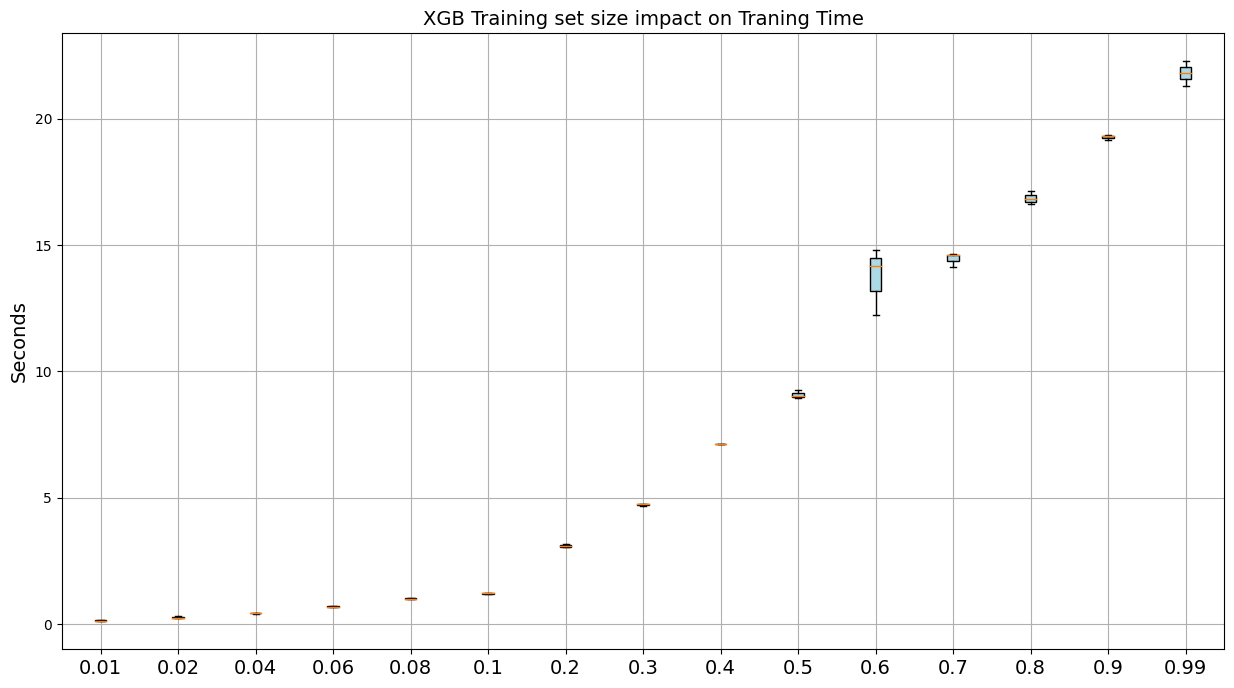

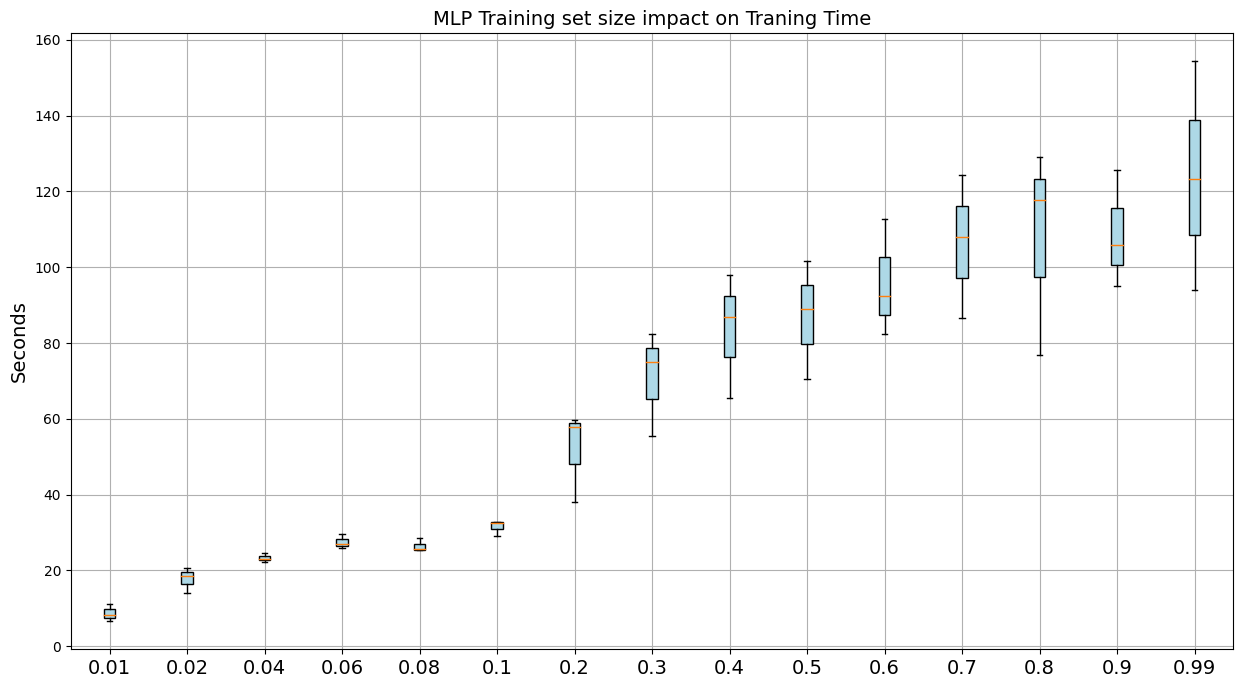

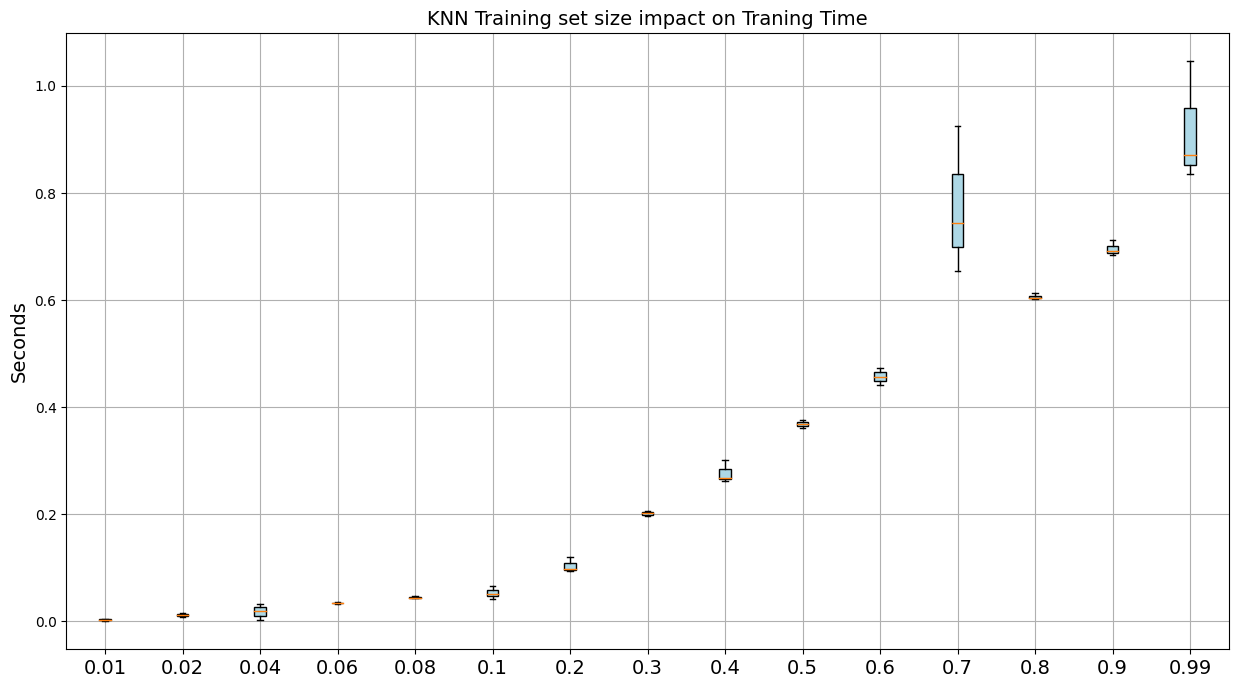

In [11]:
stats_labels = ['Accuracy', 'Global Precision', 'Global Recall', 'Global F1-score']

fig_folder = '1_4_Figures'
if not os.path.exists(fig_folder):
    os.makedirs(fig_folder)

candle_trainng_size_impact(fig_folder, 'XGB', xgb_all_ttimes)
candle_trainng_size_impact(fig_folder, 'MLP', dnn_all_ttimes)
candle_trainng_size_impact(fig_folder, 'KNN', knn_all_ttimes)

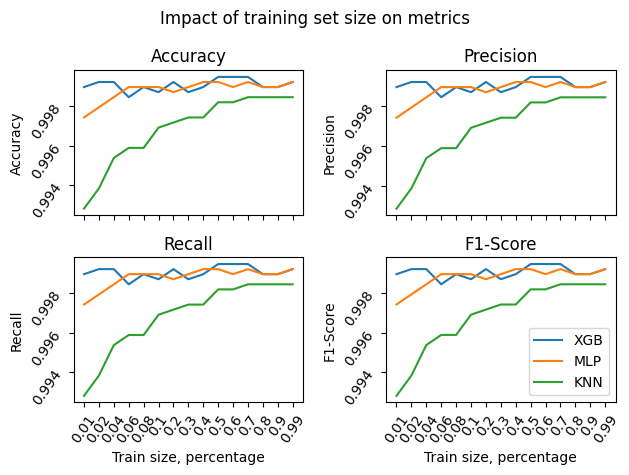

In [18]:
###############################################################################
###### Plot the 4 metrics vs training set size in 4 separate graphs
###############################################################################
        
xvalues=np.array(percentages_lables)
fig, axs = plt.subplots(2, 2)

A_XGB = [item[0] for item in XGB_all_metrics]
A_DNN = [item[0] for item in DNN_all_metrics]
A_KNN = [item[0] for item in KNN_all_metrics]
axs[0,0].plot(xvalues, A_XGB, label = 'XGB')
axs[0,0].plot(xvalues, A_DNN, label = 'MLP')
axs[0,0].plot(xvalues, A_KNN, label = 'KNN')
axs[0,0].tick_params(labelrotation=55)
axs[0,0].set_title('Accuracy')
axs[0,0].set_ylabel('Accuracy')
axs[0,0].yaxis.grid(True)

GP_XGB = [item[1] for item in XGB_all_metrics]
GP_DNN = [item[1] for item in DNN_all_metrics]
GP_KNN = [item[1] for item in KNN_all_metrics]
axs[0,1].plot(xvalues, GP_XGB, label = 'XGB')
axs[0,1].plot(xvalues, GP_DNN, label = 'MLP')
axs[0,1].plot(xvalues, GP_KNN, label = 'KNN')
axs[0,1].tick_params(labelrotation=55)
axs[0,1].set_title('Precision')
axs[0,1].set_ylabel('Precision')
axs[0,1].yaxis.grid(True)

GR_XGB = [item[2] for item in XGB_all_metrics]
GR_DNN = [item[2] for item in DNN_all_metrics]
GR_KNN = [item[2] for item in KNN_all_metrics]
axs[1,0].plot(xvalues, GR_XGB, label = 'XGB')
axs[1,0].plot(xvalues, GR_DNN, label = 'MLP')
axs[1,0].plot(xvalues, GR_KNN, label = 'KNN')
axs[1,0].tick_params(labelrotation=55)
axs[1,0].set_title('Recall')
axs[1,0].set_ylabel('Recall')
axs[1,0].yaxis.grid(True)

GF1_XGB = [item[3] for item in XGB_all_metrics]
GF1_DNN = [item[3] for item in DNN_all_metrics]
GF1_KNN = [item[3] for item in KNN_all_metrics]
axs[1,1].plot(xvalues, GF1_XGB, label = 'XGB')
axs[1,1].plot(xvalues, GF1_DNN, label = 'MLP')
axs[1,1].plot(xvalues, GF1_KNN, label = 'KNN')
axs[1,1].tick_params(labelrotation=55)
axs[1,1].set_title('F1-Score')
axs[1,1].set_ylabel('F1-Score')
axs[1,1].yaxis.grid(True)

axs[1,0].set_xlabel('Train size, percentage')
axs[1,1].set_xlabel('Train size, percentage')


axs[1,1].legend(loc='best')
fig.suptitle('Impact of training set size on metrics')
    
fig.tight_layout()
fig.savefig(fig_folder+'/metrics.png')